# Reinforcement Learning Model

In [15]:
import os
import random
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from fractions import Fraction

Preprocessing data for later use

In [16]:
# ==== PREPROCESSING ====
def preprocess(image_path, mask_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_rgb = img_rgb.astype(np.float32) / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = (mask > 127).astype(np.float32)

    return img_rgb, mask[..., np.newaxis]

def load_dataset(image_dir, mask_dir):
    image_files = sorted(os.listdir(image_dir))
    X, Y = [], []

    for fname in image_files:
        image_path = os.path.join(image_dir, fname)
        mask_name = fname.replace('.jpg', '_HGE_Seg.jpg')
        mask_path = os.path.join(mask_dir, mask_name)

        if os.path.exists(mask_path):
            img, mask = preprocess(image_path, mask_path)
            X.append(img)
            Y.append(mask)

    return np.array(X), np.array(Y)

## Defining Constants and Useful Functions##

In [17]:
IMG_SIZE = 224 # resize all of our images to 128 like with the benchmark u-net, suraj: changed to 224 from 128, starting point should be size of image
NUM_ACTIONS = 9
HISTORY_SIZE = 10 #
STATE_DIM = 4096 + NUM_ACTIONS * HISTORY_SIZE
#Changes max steps from 20 to 200
MAX_STEPS = 200
EXPERIENCE_SAMPLE_SIZE = 20
MAX_EXPERIENCE_SIZE = 1000
GAMMA = 0.1

In [18]:
@tf.function(reduce_retracing=True)
def extract_feature_tf(image, history, feature_extractor):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image.set_shape([IMG_SIZE, IMG_SIZE, 3])
    image = tf.expand_dims(image, axis=0)

    history_onehot = tf.one_hot(history, depth=NUM_ACTIONS, dtype=tf.float32)
    history_flat = tf.reshape(history_onehot, [-1])

    features = feature_extractor(image)
    features_flat = tf.reshape(features, [-1])

    return tf.concat([features_flat, history_flat], axis=0)


def compute_q(feature, model):
    return model.predict(feature, verbose=0).flatten()

def compute_mask(action, box):
  # changing from 0.1 to 0.2(alpha)
    delta_w = 0.2 * (box[2] - box[0])
    delta_h = 0.2 * (box[3] - box[1])
    x1, y1, x2, y2 = box

    if action == 0:  # move right
        x1 += delta_w
        x2 += delta_w
    elif action == 1:  # move left
        x1 -= delta_w
        x2 -= delta_w
    elif action == 2:  # move up
        y1 -= delta_h
        y2 -= delta_h
    elif action == 3:  # move down
        y1 += delta_h
        y2 += delta_h
    elif action == 4:  # zoom in (proportional)
        x1 += delta_w
        x2 -= delta_w
        y1 += delta_h
        y2 -= delta_h
    elif action == 5:  # zoom out (proportional)
        x1 -= delta_w
        x2 += delta_w
        y1 -= delta_h
        y2 += delta_h
    elif action == 6:  # vertical zoom in (squish height)
        y1 += delta_h
        y2 -= delta_h
    elif action == 7:  # horizontal zoom in (squish width)
        x1 += delta_w
        x2 -= delta_w

    # clip box to valid image bounds
    x1 = max(0, min(IMG_SIZE, x1))
    x2 = max(0, min(IMG_SIZE, x2))
    y1 = max(0, min(IMG_SIZE, y1))
    y2 = max(0, min(IMG_SIZE, y2))

    # enforce correct box ordering
    x1, x2 = sorted([x1, x2])
    y1, y2 = sorted([y1, y2])
    return [x1, y1, x2, y2]

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    inter = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return inter / float(areaA + areaB - inter + 1e-6)

def crop_image(img, box):
    x1, y1, x2, y2 = map(int, box)
    cropped = img[y1:y2, x1:x2]
    return cv2.resize(cropped, (IMG_SIZE, IMG_SIZE)) if cropped.size else np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)

## Reward Structures

In [19]:
"""
This is a section on rewards. Currently we define 3 different functions:
binary -
IoU difference -
IoU penalty area -

each of the these take in the inputs action, gt, box, and end.
"""

def reward_binary(action, gt, box, end=False, timed_out=False):
    new_iou = compute_iou(compute_mask(action, box), gt)
    old_iou = compute_iou(box, gt)

    if end:
        if timed_out:
            reward = 0
        else:
            reward = 3 if new_iou > 0.1 else -3
    else:
        reward = 1 if new_iou > old_iou else -1
    return reward

def reward_iou_diff(action, gt, box, end=False, timed_out=False):
    new_iou = compute_iou(compute_mask(action, box), gt)
    old_iou = compute_iou(box, gt)

    if end:
        if timed_out:
            reward = 0
        else:
            reward = 3 if new_iou > 0.6 else -3
    else:
        
        reward = new_iou - old_iou
    return reward

def reward_iou_area_penalty(action, gt, box, end=False, timed_out=False):
    new_box = compute_mask(action, box)
    new_iou = compute_iou(new_box, gt)
    area = (new_box[2] - new_box[0]) * (new_box[3] - new_box[1])
    norm_area = area / (IMG_SIZE * IMG_SIZE)

    if end:
        if timed_out:
            reward = 0
        else:
            reward = 3 if new_iou > 0.6 else -3
    else:
        reward = new_iou - 0.1 * norm_area
    return reward

def reward_focus_area(action, gt, box, end=False, timed_out=False):
    new_box = compute_mask(action, box)
    iou = compute_iou(new_box, gt)

    # Dimensions of current box
    box_w = new_box[2] - new_box[0]
    box_h = new_box[3] - new_box[1]
    full_area = IMG_SIZE * IMG_SIZE

    # Prevent division by zero or nonsense
    if box_w <= 0 or box_h <= 0:
        return -1

    box_area = box_w * box_h

    # If box covers entire image (initial state), give 0 reward
    if box_area >= full_area * 0.99:  # Added small tolerance for floating point
        return 0.0

    # How many times this box could fit in the full image (using float division)
    fit_multiplier = full_area / box_area

    reward = iou * fit_multiplier

    if end:
        if timed_out:
            return 0
        else:
            return 3 if iou > 0.6 else -3

    return reward

def reward_iou_diff_area(action, gt, box, end=False, timed_out=False):
    # Compute the new bounding box after applying the action.
    new_box = compute_mask(action, box)
    
    # Compute IoU of new box and old box with the ground truth.
    new_iou = compute_iou(new_box, gt)
    old_iou = compute_iou(box, gt)
    
    # Hyperparameters for tuning:
    scale_factor = 15.0         # Multiply incremental IoU change to boost the reward signal.
    area_penalty_weight = 0.05   # Weight for penalizing large bounding boxes.
    
    # Calculate the normalized area (new_box area relative to full image area).
    box_area = (new_box[2] - new_box[0]) * (new_box[3] - new_box[1])
    full_area = IMG_SIZE * IMG_SIZE
    norm_area = box_area / full_area
    
    # For non-terminal steps, reward is the scaled IoU improvement minus area penalty.
    incremental_reward = scale_factor * (new_iou - old_iou) - area_penalty_weight * norm_area

    if end:
        if timed_out:
            reward = 0
        else:
            # At terminal steps, give a clear positive or negative reward.
            # Here, if new IoU exceeds the threshold (0.6), reward is 3; otherwise, -3.
            reward = 3 if new_iou > 0.3 else -3
    else:
        reward = incremental_reward

    return reward


In [20]:
# ==== MODEL + AGENT ====
def create_q_model():
    model = Sequential([
        Dense(512, activation='relu', input_shape=(STATE_DIM,)),
        Dense(512, activation='relu'),
        Dense(NUM_ACTIONS)
    ])
    #added accuracy
    model.compile(optimizer='adam', loss='mse', metrics = ['accuracy'])
    return model

class QAgent:
    def __init__(self, model, epsilon=1.0):
        self.model = model
        self.epsilon = epsilon
        self.gamma = 0.99
        self.memory = []  

    def remember(self, transition):
        self.memory.append(transition)
        if len(self.memory) > 10000:  # optional memory cap
            self.memory.pop(0)

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(NUM_ACTIONS)
        q_values = self.model.predict(np.expand_dims(state, axis=0), verbose=0)
        return np.argmax(q_values[0])

    def train(self, batch_size=32):
        if len(self.memory) < batch_size:
            return

        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Use tf.stack instead of np.array to ensure proper tensor shape
        states = tf.stack(states)
        next_states = tf.stack(next_states)

        q_values = self.model.predict(states, verbose=0)
        next_q_values = self.model.predict(next_states, verbose=0)

        target_qs = q_values.copy()

        for i in range(batch_size):
            target = rewards[i]
            if not dones[i]:
                target += self.gamma * np.max(next_q_values[i])
            target_qs[i][actions[i]] = target

        self.model.train_on_batch(states, target_qs)



In [21]:
def train_dqn(X_train, Y_train, vgg16_model, reward_fn, epochs=10, epsilon=1.0):
    feature_extractor = tf.keras.Model(inputs=vgg16_model.input, outputs=vgg16_model.layers[20].output)
    model = create_q_model()  # should return a compiled model with input shape (STATE_DIM,)
    agent = QAgent(model, epsilon=epsilon)

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for i in range(len(X_train)):
            img, mask = X_train[i], Y_train[i]
            ys, xs = np.where(mask.squeeze() > 0)
            if len(xs) == 0 or len(ys) == 0:
                continue

            gt_box = [np.min(xs), np.min(ys), np.max(xs), np.max(ys)]
            history = [-1] * HISTORY_SIZE
            current_box = [0, 0, IMG_SIZE, IMG_SIZE]

            img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
            history_tensor = tf.convert_to_tensor(history, dtype=tf.int32)
            state = extract_feature_tf(img_tensor, history_tensor, feature_extractor)

            done, step = False, 0
            while not done:
                action = agent.select_action(state.numpy())
                next_box = current_box if action == 8 else compute_mask(action, current_box)
                end = action == 8 or step >= MAX_STEPS
                timed_out = step >= MAX_STEPS and action != 8
                reward = reward_fn(action, gt_box, current_box, end=end, timed_out=timed_out)

                if step % 100 == 0:
                    print(f"Epoch {epoch+1}, Image {i}, Step {step}, Action {action}, Reward {reward:.4f}")


                history = history[1:] + [action]
                next_crop = crop_image(img, next_box).astype(np.float32)
                next_crop_tensor = tf.convert_to_tensor(next_crop, dtype=tf.float32)
                history_tensor = tf.convert_to_tensor(history, dtype=tf.int32)
                next_state = extract_feature_tf(next_crop_tensor, history_tensor, feature_extractor)

                agent.remember((state, action, reward, next_state, end))
                state = next_state
                current_box = next_box
                step += 1
                done = end

        agent.train(batch_size=32)
        agent.epsilon = max(agent.epsilon * 0.95, 0.05)
        #agent.epsilon = max(agent.epsilon * 0.98, 0.05)

    return agent.model

In [22]:
# ==== EVALUATION ====
def evaluate_model(model, X_test, Y_test, vgg16_model):
    feature_extractor = tf.keras.Model(
        inputs=vgg16_model.input,
        outputs=vgg16_model.layers[20].output
    )

    @tf.function(reduce_retracing=True)
    def extract_feature_tf(image, history):
        image = tf.image.resize(image, [224, 224])
        image.set_shape([224, 224, 3])
        image = tf.expand_dims(image, axis=0)

        history_onehot = tf.one_hot(history, depth=NUM_ACTIONS, dtype=tf.float32)
        history_flat = tf.reshape(history_onehot, [-1])

        features = feature_extractor(image)
        features_flat = tf.reshape(features, [-1])

        return tf.concat([features_flat, history_flat], axis=0)

    ious = []
    for i in range(len(X_test)):
        img = X_test[i].astype(np.float32)
        mask = Y_test[i]

        ys, xs = np.where(mask.squeeze() > 0)
        if len(xs) == 0 or len(ys) == 0:
            continue

        gt_box = [np.min(xs), np.min(ys), np.max(xs), np.max(ys)]
        history = [-1] * HISTORY_SIZE
        current_box = [0, 0, IMG_SIZE, IMG_SIZE]

        img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
        history_tensor = tf.convert_to_tensor(history, dtype=tf.int32)
        state = extract_feature_tf(img_tensor, history_tensor)

        done, step = False, 0
        while not done:
            state_batched = tf.expand_dims(state, axis=0)
            q_values = model.predict(state_batched, verbose=0)[0]
            action = np.argmax(q_values)

            next_box = current_box if action == 8 else compute_mask(action, current_box)
            done = action == 8 or step >= MAX_STEPS
            history = history[1:] + [action]

            next_crop = crop_image(img, next_box).astype(np.float32)
            next_crop_tensor = tf.convert_to_tensor(next_crop, dtype=tf.float32)
            history_tensor = tf.convert_to_tensor(history, dtype=tf.int32)
            state = extract_feature_tf(next_crop_tensor, history_tensor)

            current_box = next_box
            step += 1

        iou = compute_iou(current_box, gt_box)
        ious.append(iou)
        print(f"Image {i}, Final IoU: {iou:.4f}")
        print("Q-values:", q_values)

    avg_iou = np.mean(ious)
    print(f"\nAverage IoU on test set: {avg_iou:.4f}")


Similar code to before evaluating binary overlap or not (i.e. we get a reward for having overlap with the ground truth).

In [23]:
def binary_overlap_score(model, image_dir, mask_dir, img_size=128):
    image_files = sorted(os.listdir(image_dir))
    total = 0
    correct = 0

    for fname in image_files:
        img_path = os.path.join(image_dir, fname)
        mask_name = fname.replace('.jpg', '_HGE_Seg.jpg')
        mask_path = os.path.join(mask_dir, mask_name)

        if not os.path.exists(mask_path):
            continue  # skip unmatched files

        # Preprocess input and ground truth
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB).astype(np.float32) / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img_size, img_size))
        mask_bin = (mask > 127).astype(np.uint8)

        # Predict
        pred = model.predict(np.expand_dims(img_rgb, axis=0))[0].squeeze().round().astype(np.uint8)

        # Check if there's any overlap
        overlap = np.logical_and(pred, mask_bin).any()

        total += 1
        if overlap:
            correct += 1

    print(f"Binary overlap score: {correct}/{total}")
    return f"{correct}/{total}", Fraction(correct, total)

In [ ]:
#print(model.predict(state, verbose=0)[0])
# Loading models
from tensorflow.keras.models import load_model

#trained_model = load_model("dqn_hemorrhage_model_binary_aug.h5", compile=False)

In [24]:
def visualize_agent_prediction(model, vgg16_model, image_dir, mask_dir, img_size=224):
    import os
    import random
    import cv2
    import numpy as np
    import tensorflow as tf
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    image_files = sorted(os.listdir(image_dir))
    sample_file = random.choice(image_files)

    img_path = os.path.join(image_dir, sample_file)
    mask_path = os.path.join(mask_dir, sample_file.replace('.jpg', '_HGE_Seg.jpg'))

    if not os.path.exists(mask_path):
        print(f"No mask found for {sample_file}. Skipping.")
        return

    # Load and normalize image
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img_gray, (img_size, img_size))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB).astype(np.float32) / 255.0

    # Load and process mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_resized = cv2.resize(mask, (img_size, img_size))
    mask_bin = (mask_resized > 127).astype(np.uint8)

    # Feature extractor
    feature_extractor = tf.keras.Model(inputs=vgg16_model.input, outputs=vgg16_model.layers[20].output)

    @tf.function
    def extract_feature_tf(image, history):
        image = tf.image.resize(image, [224, 224])
        image.set_shape([224, 224, 3])
        image = tf.expand_dims(image, axis=0)

        history_onehot = tf.one_hot(history, depth=NUM_ACTIONS, dtype=tf.float32)
        history_flat = tf.reshape(history_onehot, [-1])

        features = feature_extractor(image)
        features_flat = tf.reshape(features, [-1])
        return tf.concat([features_flat, history_flat], axis=0)

    # Inference loop
    history = [-1] * HISTORY_SIZE
    current_box = [0, 0, img_size, img_size]
    trajectory = [current_box.copy()]
    img_tensor = tf.convert_to_tensor(img_rgb, dtype=tf.float32)
    history_tensor = tf.convert_to_tensor(history, dtype=tf.int32)
    state = extract_feature_tf(img_tensor, history_tensor)

    done, step = False, 0
    while not done:
        action = np.argmax(model.predict(np.expand_dims(state.numpy(), axis=0), verbose=0)[0])
        next_box = current_box if action == 8 else compute_mask(action, current_box)
        done = action == 8 or step >= MAX_STEPS
        history = history[1:] + [action]
        next_crop = crop_image(img_rgb, next_box).astype(np.float32)
        next_crop_tensor = tf.convert_to_tensor(next_crop, dtype=tf.float32)
        history_tensor = tf.convert_to_tensor(history, dtype=tf.int32)
        state = extract_feature_tf(next_crop_tensor, history_tensor)
        current_box = next_box
        trajectory.append(current_box.copy())
        step += 1

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].imshow(img_rgb)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    overlay = img_rgb.copy()
    overlay[mask_bin == 1] = [1.0, 0.0, 0.0]
    axs[1].imshow(overlay)
    axs[1].set_title('Ground Truth Mask Overlay')
    axs[1].axis('off')

    axs[2].imshow(img_rgb)
    for box in trajectory[:-1]:
        x1, y1, x2, y2 = map(int, box)
        axs[2].add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                           linewidth=1, edgecolor='blue', facecolor='none', alpha=0.3))
    x1, y1, x2, y2 = map(int, trajectory[-1])
    axs[2].add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                       linewidth=2, edgecolor='lime', facecolor='none', linestyle='--'))
    axs[2].set_title('RL Trajectory (Blue) + Final Box (Green)')
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
#visualize_agent_prediction(model, vgg16, 'mini_dataset/train/images', 'mini_dataset/train/masks')
#visualize_agent_prediction(iou_diff_model, vgg16, 'mini_dataset/train/images', 'mini_dataset/train/masks')
#visualize_agent_prediction(iou_diff_area_model, vgg16, 'mini_dataset/train/images', 'mini_dataset/train/masks')



In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

X, Y = load_dataset('hemorrhage_CT/images', 'hemorrhage_CT/masks')
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)

augmenter = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

# Example to generate augmented images
augmented_images = []
augmented_masks = []

for img, mask in zip(X_train, Y_train):
    img = img.reshape((1,) + img.shape)  # Add batch dim
    mask = mask.reshape((1,) + mask.shape)

    img_gen = augmenter.flow(img, batch_size=1)
    mask_gen = augmenter.flow(mask, batch_size=1)

    for _ in range(2):  # Add 2 augmented versions per image
        augmented_images.append(next(img_gen)[0])
        augmented_masks.append(next(mask_gen)[0])

# Combine with original
X_train_aug = np.concatenate([X_train, np.array(augmented_images)])
Y_train_aug = np.concatenate([Y_train, np.array(augmented_masks)])


In [ ]:
#X, Y = load_dataset('hemorrhage_CT/images', 'hemorrhage_CT/masks')
#X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)

vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=True)
same_model = train_dqn(X_train_aug[:1], Y_train_aug[:1], vgg16, reward_fn = reward_binary, epochs=500, epsilon=1.0)
same_model.save("dqn_hemorrhage_model_same_500.h5")
#trained_model = train_dqn(X_train_aug, Y_train_aug, vgg16, reward_fn = reward_iou_diff_area, epochs=15, epsilon=1.0)
#trained_model.save("dqn_hemorrhage_model_diff_area_aug.h5")

Epoch 1/500
Epoch 1, Image 0, Step 0, Action 8, Reward -3.0000
Epoch 2/500
Epoch 2, Image 0, Step 0, Action 4, Reward 1.0000
Epoch 3/500
Epoch 3, Image 0, Step 0, Action 4, Reward 1.0000
Epoch 4/500
Epoch 4, Image 0, Step 0, Action 8, Reward -3.0000
Epoch 5/500
Epoch 5, Image 0, Step 0, Action 8, Reward -3.0000
Epoch 6/500
Epoch 6, Image 0, Step 0, Action 0, Reward 1.0000
Epoch 7/500
Epoch 7, Image 0, Step 0, Action 6, Reward 1.0000
Epoch 8/500
Epoch 8, Image 0, Step 0, Action 1, Reward 1.0000
Epoch 9/500
Epoch 9, Image 0, Step 0, Action 8, Reward -3.0000
Epoch 10/500
Epoch 10, Image 0, Step 0, Action 0, Reward 1.0000
Epoch 11/500
Epoch 11, Image 0, Step 0, Action 1, Reward 1.0000
Epoch 12/500
Epoch 12, Image 0, Step 0, Action 0, Reward 1.0000
Epoch 13/500
Epoch 13, Image 0, Step 0, Action 4, Reward 1.0000
Epoch 14/500
Epoch 14, Image 0, Step 0, Action 5, Reward -1.0000
Epoch 15/500
Epoch 15, Image 0, Step 0, Action 0, Reward 1.0000
Epoch 16/500
Epoch 16, Image 0, Step 0, Action 1, Rew

In [ ]:
evaluate_model(trained_model, X_temp, Y_temp, vgg16)

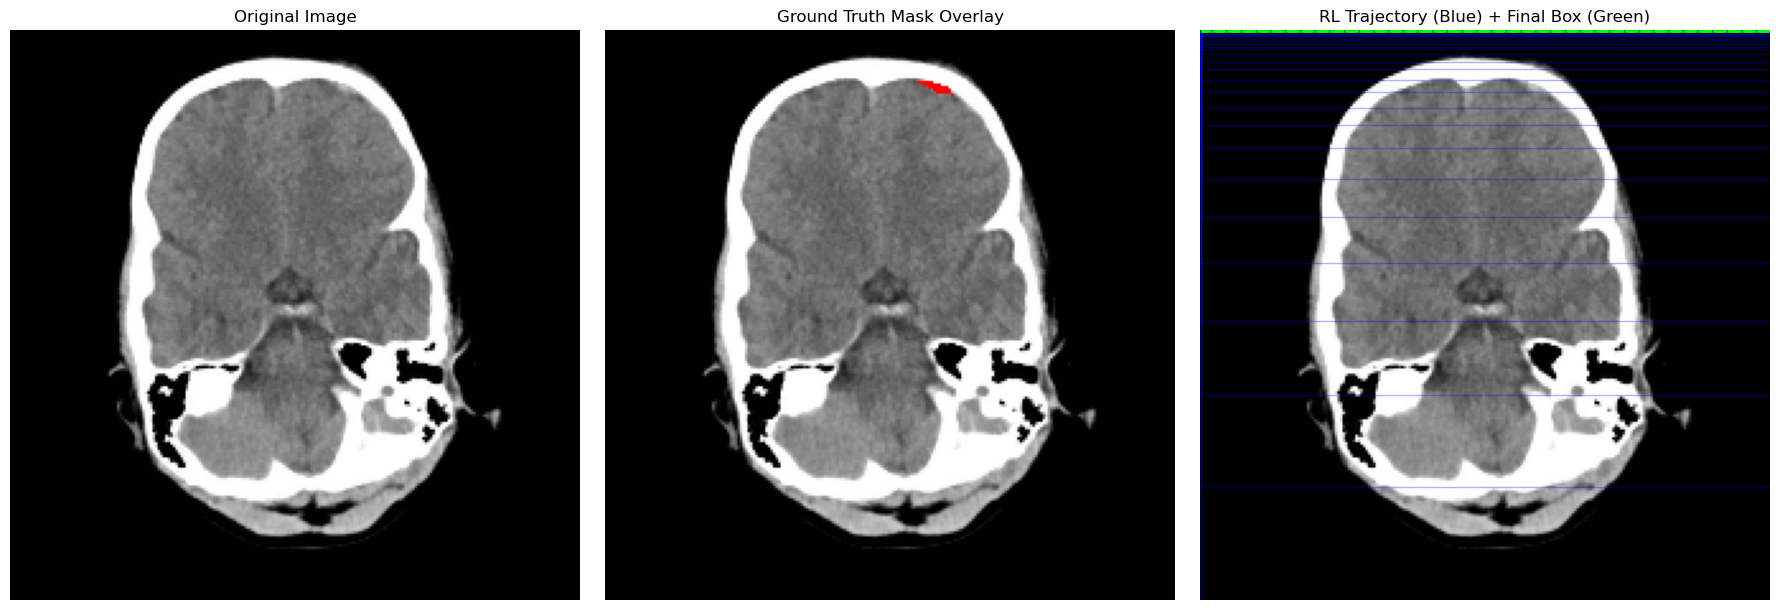

In [13]:
visualize_agent_prediction(trained_model, vgg16, 'hemorrhage_CT/images', 'hemorrhage_CT/masks')

In [ ]:
def full_image_iou_score(image_dir, mask_dir, img_size=128):
    image_files = sorted(os.listdir(image_dir))
    sample_file = random.choice(image_files)

    # Paths
    img_path = os.path.join(image_dir, sample_file)
    mask_path = os.path.join(mask_dir, sample_file.replace('.jpg', '_HGE_Seg.jpg'))

    if not os.path.exists(mask_path):
        print(f"Mask not found for {sample_file}. Skipping.")
        return

    # Load and preprocess
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (img_size, img_size))
    mask_bin = (mask > 127).astype(np.uint8)

    ys, xs = np.where(mask_bin > 0)
    if len(xs) == 0 or len(ys) == 0:
        print(f"No tumor in mask for {sample_file}.")
        return

    # Define ground truth box
    gt_box = [np.min(xs), np.min(ys), np.max(xs), np.max(ys)]

    # Define prediction as full image
    pred_box = [0, 0, img_size, img_size]

    # Compute IoU
    iou = compute_iou(pred_box, gt_box)
    print(f"Sample: {sample_file}")
    print(f"Ground Truth Box: {gt_box}")
    print(f"Predicted Full Image Box: {pred_box}")
    print(f"IoU: {iou:.4f}")
    return iou

full_image_iou_score('hemorrhage_CT/images', 'hemorrhage_CT/masks')

In [ ]:
vals = []
for _ in range(20):
    vals.append(full_image_iou_score('hemorrhage_CT/images', 'hemorrhage_CT/masks'))
print("average overall: ", np.mean(vals))

In [ ]:
# model_binary = tf.keras.models.load_model('dqn_mini_model.keras')
visualize_agent_prediction(model_binary, vgg16, 'mini_dataset/train/images', 'mini_dataset/train/masks')

In [ ]:
def visualize_pre_cnn_input(image_path, mask_path):
    # --- Load original image and mask ---
    original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if original is None or mask is None:
        print("Missing file.")
        return

    # Resize for CNN
    resized_image = cv2.resize(original, (224, 224))
    resized_mask = cv2.resize(mask, (224, 224))

    # Normalize + convert to RGB for consistency
    img_rgb = cv2.cvtColor(original, cv2.COLOR_GRAY2RGB).astype(np.float32) / 255.0
    mask_bin = (mask > 127).astype(np.uint8)
    resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB).astype(np.float32) / 255.0
    resized_mask_bin = (resized_mask > 127).astype(np.uint8)

    # Create overlays
    overlay_original = img_rgb.copy()
    overlay_original[mask_bin == 1] = [1.0, 0.0, 0.0]  # red

    overlay_resized = resized_rgb.copy()
    overlay_resized[resized_mask_bin == 1] = [1.0, 0.0, 0.0]  # red

    # Plotting
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(original, cmap='gray')
    axs[0].set_title('Original Image')
    axs[1].imshow(overlay_original)
    axs[1].set_title('Original + Mask Overlay')
    axs[2].imshow(resized_image, cmap='gray')
    axs[2].set_title('Resized for CNN (224×224)')
    axs[3].imshow(overlay_resized)
    axs[3].set_title('Resized + Mask Overlay')

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
image_path = 'mini_dataset/test/images/051_30.jpg'
mask_path = 'mini_dataset/test/masks/051_30_HGE_Seg.jpg'
visualize_pre_cnn_input(image_path, mask_path)